<a href="https://colab.research.google.com/github/PaleoLipidRR/marine-AOA-GDGT-distribution/blob/main/PNAS_pythonCodeS1_BeyondTEX86_preprocessing_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Code S1**

## Supplementary Information for:
## Beyond TEX86: GDGT inform marine archaea ecology and evolution
Ronnakrit Rattanasriampaipong, Yi Ge Zhang, Ann Pearson, Brian Hedlund, and Shuang Zhang

Corresponding Author: Ronnakrit Rattanasriampaipong
E-mail: rrattan@tamu.edu
***

Notebook Description:

This is a jupyter containing python scripts that we use to pre-process GDGT database and generate the processed GDGT datasets (output as Dataset S1) to be used for data analysis. The input file (Dataset S1) is a composite GDGT database used for this study from the Python Code S1 (see SI Appendix).

***


# **1. Import python packages of interest**

### 1.1 Mounting your google drive with Google colab so that you can read files directly from the google drive (when you run this notebook on Google Colab)

In [ ]:
# # Mounting your google drive
# from os.path import join
# from google.colab import drive

# ROOT = "/content/drive"
# drive.mount(ROOT,force_remount=True)


### 1.2 Computation and Data Analytics

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)
import seaborn as sns

import scipy as scipy
from scipy import stats
from sklearn import linear_model, datasets
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score

### 1.2 Data plotting and visualizations

**Uncomment !apt-get if you run this notebook from Colab.**

In [ ]:
# !apt-get install libproj-dev proj-data proj-bin
# !apt-get install libgeos-dev
# %pip install cartopy
# !apt-get -qq install python-cartopy python3-cartopy
# %pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
# %pip install shapely --no-binary shapely

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle

import proplot as plot
import cartopy.crs as ccrs

from pyrolite.util.time import Timescale
gts = Timescale()


ModuleNotFoundError: ignored

###  1.3 pyGplates: Plate reconstructions 

In [ ]:
import pygplates

from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

###  1.4 Miscellaneous

In [ ]:
import string
import os
import requests
import io

from distributed import Client

###  1.5 Useful functions

In [3]:
def sigmaT_cal_Miller_and_Poisson_1981(temp_array,sal_array):
    '''
    This is a function for seawater density (sigma-t) calculation based on seawater temperature and salinity.
    The calculations follow Miller and Poisson (1981).
    
    Reference:
    Millero, F. J., & Poisson, A. (1981). International one-atmosphere equation of state of seawater. Deep Sea Research Part A. 
    Oceanographic Research Papers, 28(6), 625-629.
    '''
    #Miller and Poisson (1981)
    #parameter for sigma calculation
    A = 8.24493e-1 - 4.0899e-3*temp_array + 7.6438e-5*(temp_array**2) - 8.2467e-7*(temp_array**3) + 5.3875e-9*(temp_array**4)
    B = -5.72466e-3 + 1.0227e-4*temp_array - 1.6546e-6*(temp_array**2)
    C = 4.8314e-4
    rho_0=999.842594 + 6.793952e-2*temp_array - 9.095290e-3*(temp_array**2) + 1.001685e-4*(temp_array**3) - 1.120083e-6*(temp_array**4) + 6.536336e-9*(temp_array**5)
    rho=rho_0 + (A*sal_array) + (B*(sal_array**1.5)) + (C*(sal_array**2))
    return rho-1000

def rollmean_calculation_step(sel_df,sel_attribute,younger_age,older_age,bin_step):
    '''
    sel_attribute is the column name e.g., 'paleoDepth_adjusted'
    
    Return the array with 5 columns:
    array_rollmean[:,0:4]
    0: plot_timestep
    1: mean
    2: median
    3: lower iqr (percentile 25th)
    4: upper iqr (percentile 75th)
    5: minimum of data range (percentile 0)
    6: maximum of data range (percentile 100)
    '''
    
    attributes = [sel_attribute]
    
    plot_timestep = np.arange(younger_age,older_age+bin_step,bin_step)
    nbins = len(plot_timestep)
    array_rollmean = np.empty((nbins,7))
    array_rollmean[:,0] = plot_timestep

    min_counts = 3


    sel_group = sel_df[sel_df.dataType_level0=="Ancient"]

    for i in range(len(array_rollmean[:,0])):
        if sel_group[sel_attribute].where((sel_group.sampleAge>=plot_timestep[i])&
                                          (sel_group.sampleAge<plot_timestep[i]+bin_step)).count() <=min_counts:
            array_rollmean[i,1] = np.nan
            array_rollmean[i,2] = np.nan
            array_rollmean[i,3] = np.nan
            array_rollmean[i,4] = np.nan
            array_rollmean[i,5] = np.nan
            array_rollmean[i,6] = np.nan


        else:
            bin_data = sel_group[sel_attribute].where((sel_group.sampleAge>=plot_timestep[i])&
                                                      (sel_group.sampleAge<plot_timestep[i]+bin_step))
            array_rollmean[i,1] = bin_data[~np.isnan(bin_data)].mean()
            
            a = scipy.stats.mstats.mquantiles(bin_data[~np.isnan(bin_data)], prob=[0,0.25, 0.5, 0.75,1], alphap=0.4, betap=0.4,axis=None, limit=())
            array_rollmean[i,2] = a[2]
            array_rollmean[i,3] = a[1]
            array_rollmean[i,4] = a[3]
            
            array_rollmean[i,5] = a[0]
            array_rollmean[i,6] = a[4]


            
    return array_rollmean



def _woa_variable(variable):
    '''
    codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
    variables:
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
   time_periods:
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
   resolutions:
    '5': ('5deg', '5d'),
    '1': ('1.00', '01'),
    '04': ('0.25', '04'),
        

    an=Objectively analyzed climatologies are the objectively interpolated mean fields 
    for oceanographic variables at standard depth levels for the World Ocean.
    mn=The statistical mean is the average of all unflagged interpolated values at each 
    standard depth level for each variable in each 1° square which contains at least one
    '''
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature']:
        pref = 'woa18'
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        return (
            f'{base}'
            '/ncei/woa/'
            f'{variable}/all/{res}/'
            f'{pref}_all_{v}{tt}_{gg}.nc'
        )
    else:
        dddd = 'decav'
        pref = 'woa18'




    url = (
        f'{base}'
        '/ncei/woa/'
        f'{variable}/decav/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )
    return url




---



# **2. Load and clean datasets**

In [ ]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
# filepath = "/content/drive/MyDrive/Colab Notebooks/Excel/MarineAOA_project/"  ### Replace with your the location of your file
filepath = "C:/Users/ratta/marine-AOA-GDGT-distribution/spreadsheets/"
filename = "PNAS_datasetS1_BeyondTEX86_RR.xlsx"

df = pd.read_excel(filepath+filename)
df = df.rename(columns={
                        'Sample Age (Ma)':'sampleAge',
                        'Broad Filtration Class':'lipidClass',
                        'Lipid Extractions':'lipidExtractionMethod',
                        'Filter pore size':'filterPoreSize',
                        'Geological Age\n(Name)':'geoEpoch'
                       })
df.columns

Index(['sampleName', 'drilling_program', 'Site', 'Site_edited', 'Latitude',
       'Longitude', 'Collection_date', 'Collection_year', 'Collection_month',
       'Seasonal_month', 'sampleID_new', 'modernWaterDepth', 'sampleDepth',
       'sampleAge', 'reported_Temp', 'reported_T_method', 'reported_Salinity',
       'reported_S_method', 'reported_pH', 'reported_pH_method', 'lipidClass',
       'lipidExtractionMethod', 'filterPoreSize', 'reported_1302',
       'reported_1300', 'reported_1928', 'reported_1296', 'reported_1294',
       'reported_1292', 'reported_1292_iso', 'reported_1050',
       'reported_1050_isomer1', 'reported_1048', 'reported_1048_isomer1',
       'reported_1046', 'reported_1046_isomer1', 'reported_1036',
       'reported_1036_isomer1', 'reported_1034', 'reported_1034_isomer1',
       'reported_1032', 'reported_1032_isomer1', 'reported_1022',
       'reported_1020', 'reported_1018', 'cal_frac_1302', 'cal_frac_1300',
       'cal_frac_1298', 'cal_frac_1296', 'cal_frac_12

## 2.1 First, we remove data points that may be below detection limit (BDL)
Data points with very low reported raw/fractional abundances (<=0.001) of isoGDGTs will be removed.

In [ ]:
def BDL_histogram():
  fig, axs = plot.subplots(ncols=2,nrows=6,figsize=(6,6),wratios=(3,1),wspace='1em',hspace='1em')
  axs.format(
      suptitle="Histograms show distributions of each GDGT fraction",
      xlabel=""
  )

  features = ['cal_frac_1302','cal_frac_1300','cal_frac_1298','cal_frac_1296','cal_frac_1292','cal_frac_1292_iso']
  title_labels = ['GDGT-0','GDGT-1','GDGT-2','GDGT-3','Cren',"Cren'"]
  ii = 0
  jj = 1

  for i in range(6):
      ax = axs[ii]
      data = df[features[i]]
      n, bins, patches = ax.hist(data,bins=np.arange(0,1,0.001),edgecolor=None,color='0.5')
      patches[0].set_fc('r')
      ii += 2
      ax.format(
          urtitle=title_labels[i]
      )

      
      ax = axs[jj]
      n, bins, patches = ax.hist(data,bins=np.arange(0,1,0.001),edgecolor=None,color='0.5')
      patches[0].set_fc('r')
      ax.format(
          xlim=(-0.02,0.05)
      )
      jj += 2
      
      ax.format(
          urtitle=title_labels[i]
      )
  plt.show()

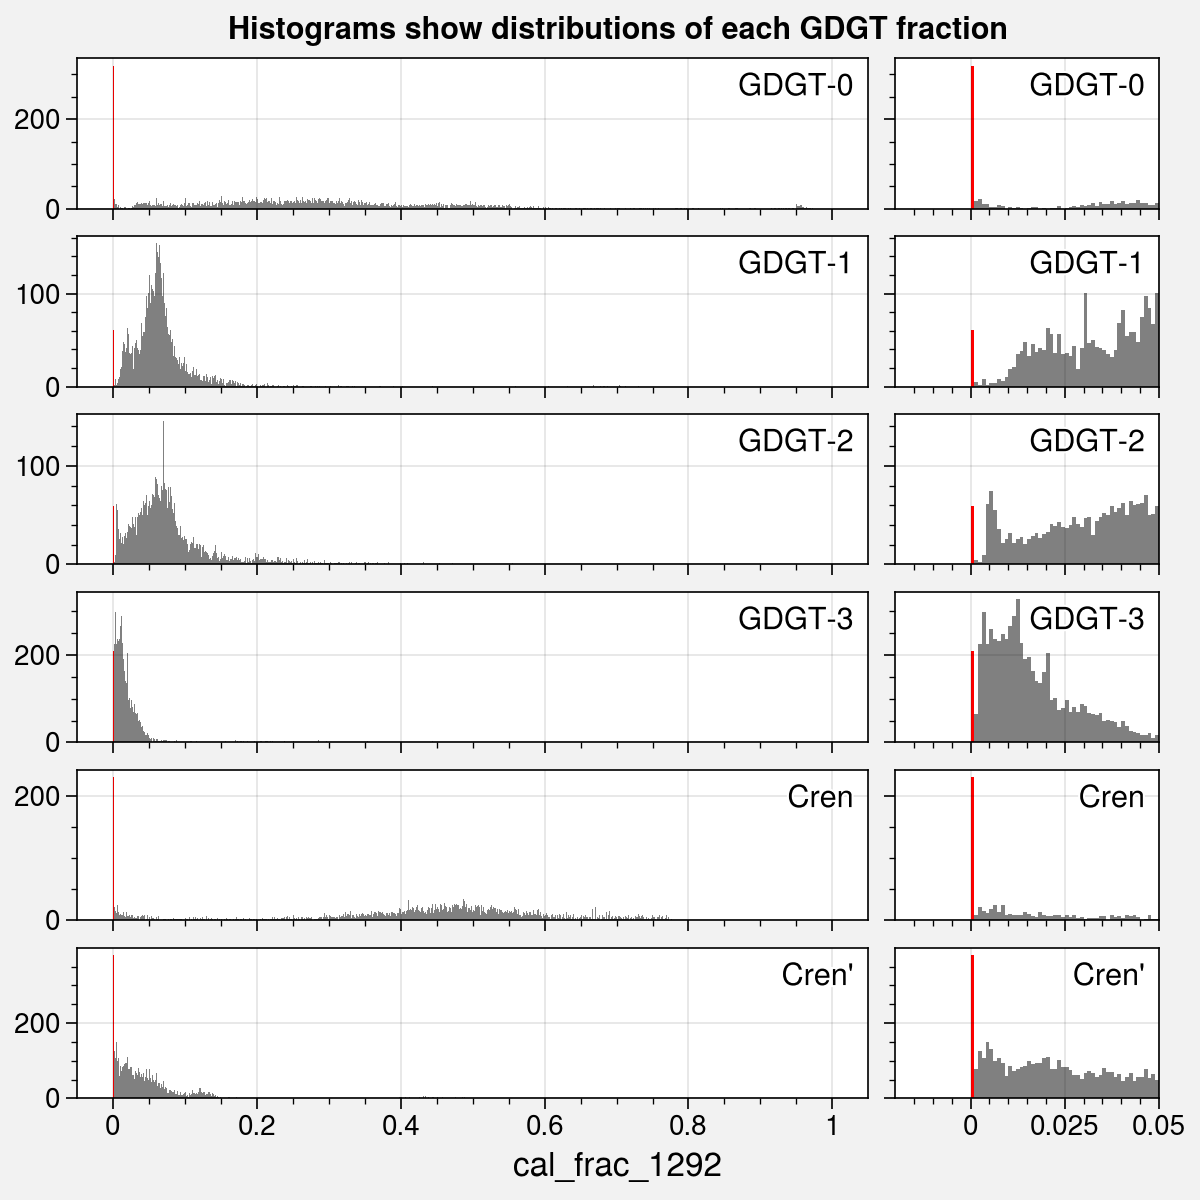

In [ ]:
BDL_histogram()

**Run the code below to remove data points with abundances <= 0.001**

In [ ]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
#First, remove rows with too low abundaces
df_checked = df[df.detectionLimit_check=='Pass']
df_hs = df[df.dataType_level1=='Culture - Hot spring']
frame = [df_checked,df_hs]
df2 = pd.concat(frame)
df2 = df2.reset_index()
df2 = df2.drop(columns='index')
df2.dataType_level1.unique()

array(['Mesozoic', 'Late Cenozoic', 'Culture - ThAOA', 'Water-column SPM',
       'Early Cenozoic', 'Hot spring', 'Culture - AOA',
       'Culture - SoilAOA', 'Core top',
       'Culture - AOA (Calculated; Multiple Strain)',
       'Culture - Hot spring'], dtype=object)

## **2.2 Next, we will remove duplicate entries**

### **2.2.1 Datasets that have multiple sources will be selected from the reported newer/updated/reanalysed datasets**

**Below is an example of datasets that are duplicates of newer reported information**

In [ ]:
df2[df2.duplicate_Datasets=='Yes']

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
398,Inglis2015_1172_01,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,Peter,https://doi.org/10.1038/nature08399,NaN,NaN,NaN
399,Inglis2015_1172_02,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,Peter,https://doi.org/10.1038/nature08400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2244,TT2015_769_54,N/A-coretop,Offshore NW Brazil; Amazon River,Western Equatorial Atlantic,0.66,...,Claudia,https://doi.org/10.1016/j.gca.2014.04.038,NaN,NaN,NaN
2245,TT2015_770_60b,N/A-coretop,Offshore NW Brazil; Amazon River,Western Equatorial Atlantic,-1.03,...,Claudia,https://doi.org/10.1016/j.gca.2014.04.038,NaN,NaN,NaN


In [ ]:
df2 = df2[df2.duplicate_Datasets=='No']

### **2.2.2 Datasets with multiple lipid classes**

Our data compilation contain all reported lipid classes including core lipids (CLs), intact polar lipids (IPLs), and/or total GDGTs.

For our data analysis, we prioritize total GDGTs over CLs. IPLs will be analyzed separately. If a dataset reporting lipid classes more than one types, we retain only total GDGTs in the dataframe for further analysis.

From the pivot table below, you can see that some datasets provide multiple lipid classes of GDGTs, such as Bijl et al. (2021)

In [ ]:
pd.set_option('display.max_rows',10)
pivoted = df2.pivot_table(index=('Source2','dataType_level1','lipidClass'),values='gdgt23ratio',aggfunc=lambda x: len(x.unique()))
pivoted.head(10)

gdgt23ratio
Source2                 dataType_level1  lipidClass              
Alsenz et al. (2013)    Mesozoic         paleoGDGTs            95
Auderset et al. (2019)  Late Cenozoic    paleoGDGTs           194
Bale et al. (2019)      Culture - ThAOA  Total GDGTs            3
Basse et al. (2014)     Water-column SPM CL-GDGTs              83
Besseling et al. (2019) Water-column SPM CL-GDGTs              22
Bijl et al. (2021)      Early Cenozoic   paleoGDGTs           263
                        Late Cenozoic    paleoGDGTs            13
                        Mesozoic         paleoGDGTs            30
Bornemann et al. (2008) Mesozoic         paleoGDGTs            39
Bottini et al. (2015)   Mesozoic         paleoGDGTs             9

**Below is a python script to remove duplicate data entries from datasets with multiple lipid classes**

df2_main is the main dataframe that contains mainly Total GDGTs. For some datasets, CL-GDGTs will be used when the total GDGTs are not available.

In [ ]:
pd.set_option('display.max_rows',8)
grouped = df2.groupby(['Source2','dataType_level1'])

interim_df = []
for i, (name, group) in enumerate(grouped):
    if len(group.lipidClass.unique())>1:
        group = group[group.lipidClass=='Total GDGTs']
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df = new_df.reset_index()
df2_main = new_df.drop(columns='index')
df2_main

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
0,Alsenz2013_Aderet1_01,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
1,Alsenz2013_Aderet1_02,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
2,Alsenz2013_Aderet1_03,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
3,Alsenz2013_Aderet1_04,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4799,vanHelmond2015_Wunstorf_44,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN
4800,vanHelmond2015_Wunstorf_45,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN
4801,vanHelmond2015_Wunstorf_46,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN
4802,vanHelmond2015_Wunstorf_47,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN


2. df2_SPM is the secondary dataframe that contains only IPL-GDGTs from all data types

In [ ]:
df2_IPL = df2[df2.lipidClass=='IPL-GDGTs']
df2_IPL = df2_IPL.reset_index()
df2_IPL = df2_IPL.drop(columns='index')
df2_IPL.head(10)

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
0,Boyd2013_026_P-GDGT_E01,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.7275,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,6.4,0.5,0.3
1,Boyd2013_036_P-GDGT_E11,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.726611,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.7,0.0,0.0
2,Boyd2013_037_P-GDGT_E12,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.304944,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.3,0.0,0.0
3,Boyd2013_038_P-GDGT_E14,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.305222,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,10.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6,Boyd2013_043_P-GDGT_E22,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.304778,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.1,0.0,0.0
7,Boyd2013_044_P-GDGT_E24,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.531833,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.1,0.0,0.0
8,Boyd2013_045_P-GDGT_E26,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.531833,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.1,0.0,0.0
9,Boyd2013_049_P-GDGT_E36,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.751917,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,6.6,0.1,0.1


## **2.3 Then, remove GDGT data that are associated with hot springs that the pH <6.5**
In this project, we would like to compare the GDGT cyclization between marine environments and their (hyper)thermophilic counterparts. As marine AOA biosynthesize Crenarchaeol and its regioisomer (Cren') molecules, we will extract hot springs GDGTs that are coming from sites where the pH is higher than 6.5 as these archaea will not synthesize Cren and Cren' in acidic environments.

### 2.3.1 Filtering **df2_main** dataframe to **df2_main_pH**

In [ ]:
pd.set_option('display.max_rows',8)
grouped = df2_main.groupby(['dataType_level1'])

interim_df = []
for i, (name, group) in enumerate(grouped):
    if 'Hot spring' in name:
        group.reported_pH = group.reported_pH.replace('>7',float(7))
        group.reported_pH = pd.to_numeric(group.reported_pH,errors='coerce')
        group = group[group.reported_pH>=6.5]
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df = new_df.reset_index()
df2_main_pH = new_df.drop(columns='index')
df2_main_pH[df2_main_pH.dataType_level1=='Hot spring'].reported_pH.unique()

array([7.17, 7.46, 8.49, 9.3, 9.1, 8.88, 8.5, 8.2, 7.0, 8.3, 7.35, 7.49,
       8.23, 8.74, 8.4, 8.6, 6.9, 6.69, 8.01, 7.12, 6.67, 6.86, 9.4, 8.0,
       7.3, 6.7, 9.2, 9.0, 9.5, 9.6, 10.1, 7.9, 7.8, 7.5, 8.8, 7.1, 6.8,
       6.6], dtype=object)

### 2.3.2 Filtering **df2_IPL** dataframe to **df2_IPL_pH**

In [ ]:
pd.set_option('display.max_rows',8)
grouped = df2_IPL.groupby(['dataType_level1'])

interim_df = []
for i, (name, group) in enumerate(grouped):
    if 'Hot spring' in name:
        group.reported_pH = group.reported_pH.replace('>7',float(7))
        group.reported_pH = pd.to_numeric(group.reported_pH,errors='coerce')
        group = group[group.reported_pH>=6.5]
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df = new_df.reset_index()
df2_IPL_pH = new_df.drop(columns='index')
df2_IPL_pH[df2_IPL_pH.dataType_level1=='Hot spring'].reported_pH.unique()

array([7.46, 8.49, 9.1, 9.57, 8.88, 8.5, 8.4, 8.6, 8.2, 7.0, 6.9, 9.3,
       9.4, 8.0, 7.44, 7.3, 6.7, 7.2, 7.5, 9.5, 9.6, 8.9, 7.9, 8.1, 7.8,
       6.6, 6.8, 7.1, 8.3], dtype=object)

# **3. Import WOA18 data and generate seawater density (sigma-T)**

## 3.1 Import data

### 3.1.1 Annual average dataset from the multi-decadal climatologies (0.25degx0.25deg; 1955-2017)

In [ ]:
#### Uncomment this cell if you have netcdf files in your local directory
# filepath = "C:/Users/ratta/OneDrive - Texas A&M University/Marine AOA Evolution_shared/Desktop/netcdf/"  ### change filepath to your local directory
# ts_decav_filename = 'woa18_decav_t00_04.nc'
# ts = xr.open_mfdataset(filepath+ts_decav_filename,decode_times=False,chunks={'time':1,'depth':1,'lon':100})

# ss_decav_afilname = 'woa18_decav_s00_04.nc'
# ss = xr.open_mfdataset(filepath+ss_decav_filname,decode_times=False,chunks={'time':1,'depth':1,'lon':100})

In [ ]:
import netCDF4

In [5]:
url = _woa_url('temperature','00','04')
ts = xr.open_dataset(url,decode_times=False,chunks={'time':1,'depth':1,'lon':100})
ts

<xarray.Dataset>
Dimensions:             (depth: 102, lat: 720, lon: 1440, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(100, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 100), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [ ]:
url = _woa_url('salinity','annual','04')
print("Data source: "+str(url))
ss = xr.open_dataset(url,decode_times=False,chunks={'time':1,'depth':1,'lon':100})
ss

## 3.2 Calculate seawater density (sigma-T) from imported temperture and salinity following Millero and Poission (1981)

Reference: <br>
Millero, F. J., & Poisson, A. (1981). International one-atmosphere equation of state of seawater. Deep Sea Research Part A. Oceanographic Research Papers, 28(6), 625-629.

### **3.2.1 Annual average of Sigma-T climatologies**

In [ ]:
#Load t_an and s_an data
t_an_all = ts.t_an.isel(time=0)
s_an_all = ss.s_an.isel(time=0)

sel_t = t_an_all
sel_s = s_an_all

sigma_all=sigmaT_cal_Miller_and_Poisson_1981(sel_t,sel_s)
sigma_all

### **3.2.2 Monthly average of Sigma-T climatologies**

In [ ]:
#Load t_an and s_an data
t_an_all_mon = ts_mon.t_an
s_an_all_mon = ss_mon.s_an

sel_t = t_an_all_mon
sel_s = s_an_all_mon

sigma_all_mon=sigmaT_cal_Miller_and_Poisson_1981(sel_t,sel_s)
sigma_all_mon

### **3.2.3 Standard deviation volution of monthly average of Sigma-T climatologies**

In [ ]:
sigma_mon_std = sigma_all_mon.std(dim='time')
sigma_mon_std

In [ ]:
def fig_permanent_pycnocline():
    rc_params = {
        'fontsize': 10,
        'fontname': 'Tex Gyre Heros',
        'text.labelsize':10,
    }
    plot.rc.update(rc_params)

    fig, axs = plot.subplots(width=6.5,height=3)
    ax = axs[0]
    ax.format(
        ltitle='    25°W Meridional Section of the Atlantic Ocean',
        ylim=(0,800),
        yreverse=True,
        xformatter='deglat',
        xlabel=''
    )

    ############INPUT DATA from WOA18 decav and monav #####################
    sigma25W_decav = sigma_all.sel(lon=-25,method='nearest').values
    # sigma170W_decav = sigma_all.sel(lon=-170,method='nearest').values
    lon_decav = sigma_all.lon.values
    lat_decav = sigma_all.lat.values
    depth_decav = sigma_all.depth.values


    # sigmaSTD_0m = sigma_mon_std.sel(depth=0,method='nearest').values
    sigmaSTD_25W = sigma_mon_std.sel(lon=-25,method='nearest').values
    # sigmaSTD_170W = sigma_mon_std.sel(lon=-170,method='nearest').values
    lon_STD = sigma_mon_std.lon.values
    lat_STD = sigma_mon_std.lat.values
    depth_STD = sigma_mon_std.depth.values 
    CB = ax.contourf(lat_STD,depth_STD,sigmaSTD_25W,
                      vmin=0,vmax=1,levels=10,cmap='blues_r'
                    )
    CS0 = ax.contour(lat_STD,depth_STD,sigmaSTD_25W,
                      vmin=0,vmax=1,levels=10,cmap='blues_r'
                    )
    CS0.collections[1].set_lw(1.5)
    CS0.collections[1].set_ls('--')
    CS0.collections[1].set_color('w')


    CS1 = ax.contour(
        lat_decav,depth_decav,
        sigma25W_decav,
        vmin=20,vmax=30,
        levels=np.linspace(20,30,21),
        color='w',
        lw=0.5,
    )

    ax.clabel(CS1,np.linspace(20,29,10),fmt='%1.0f')

    ########### Pacific section
    # ax = axs[3]
    # ax.format(
    #     ylim=(0,800),
    #     yreverse=True,
    #     xformatter='deglat',
    # )
    # ax.contourf(lat_STD,depth_STD,sigmaSTD_170W,
    #             vmin=0,vmax=1,levels=10,cmap='Oxy_r'
    #             )
    # CS2 = ax.contour(
    #     lat_decav,depth_decav,
    #     sigma170W_decav,
    #     vmin=20,vmax=30,
    #     levels=np.linspace(20,30,21),
    #     color='k',
    #     lw=0.5,
    # )

    # ax.clabel(CS2,np.linspace(20,29,10),fmt='%1.0f')

    # axs[0].format(yreverse=True)

    ax.colorbar(CB,loc='l',boundaries=np.linspace(0,1,10),col=[1,2],
                label="Sigma-T standard deviation")

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    x1, y1 = 40, 90
    x2, y2 = 0, 300
    ax.annotate("Permanent Pycnocline",color='w',
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color="w",
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                ),
                )
    plt.show()
    # filepath = 'D:\\OneDrive - Texas A&M University\\Marine AOA Evolution_shared\\Figure\\python_export\\'
    # # filepath = 'C:\\Users\\ratta\\OneDrive - Texas A&M University\\Marine AOA Evolution_shared\\Figure\\python_export\\'
    # figname = 'pycnocline_atlantic'
    # fig.savefig(filepath+figname+'.png',dpi=300,bbox_inches='tight')

In [ ]:
fig_permanent_pycnocline()

# **4. Import paleowater depth gridded data from PaleoDEMS project (Scotese and Wright, 2018)**

Reference:<br>
Scotese, C. R., & Wright, N. (2018). PALEOMAP Paleodigital Elevation Models (PaleoDEMS) for the Phanerozoic PALEOMAP Project.

Resource:<br>
https://www.earthbyte.org/paleodem-resource-scotese-and-wright-2018/

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/paleoDEMS/"
filename = "PaleoDEMS_elevation_Scotese_Wright_2018.nc"

ds_paleoDEM = xr.open_mfdataset(filepath+filename)
ds_paleoDEM.elev.values = ds_paleoDEM.elev.values*(-1)
ds_paleoDEM

# **5. Matching water properties and paleo-water depth to database**

In [ ]:
df2_main_pH.dataType_level1.unique()

In [ ]:
#loop to get data
import time
start_time = time.time()

### Variables that we will match from WOA18
df2_main_pH['WOA18_decav_insituT'] = np.nan
df2_main_pH['WOA18_decav_SST'] = np.nan
df2_main_pH['WOA18_decav_insituS'] = np.nan
df2_main_pH['WOA18_decav_SSS'] = np.nan 

df2_main_pH['WOA18_decav_insitu_sigmaT'] = np.nan
df2_main_pH['WOA18_decav_surface_sigmaT'] = np.nan
df2_main_pH['WOA18_decav_insitu_sigmaT_std'] = np.nan

df2_main_pH['match_depth'] = np.nan
df2_main_pH['match_lat'] = np.nan
df2_main_pH['match_lon'] = np.nan
df2_main_pH['oceanLayer_class'] = np.nan

grouped = df2_main_pH.groupby('dataType_level1')

lat_data = pd.to_numeric(df2_main_pH.Latitude, errors='coerce')
lon_data = pd.to_numeric(df2_main_pH.Longitude, errors='coerce')
depth_data = pd.to_numeric(df2_main_pH.modernWaterDepth, errors='coerce')

for name, group in grouped:
  if (name == 'Water-column SPM')|(name == 'Core top'):
    for i in range(len(lat_data)): #len(df3.Latitude)
          selected_t = t_an_all.sel(
                            lat=lat_data.iloc[i],
                            lon=lon_data.iloc[i],
                            depth=depth_data.iloc[i],
                            method='nearest',
                          )
          selected_sst = t_an_all.sel(
                            lat=lat_data.iloc[i],
                            lon=lon_data.iloc[i],
                            depth=0,
                            method='nearest'
                          )
          selected_s = s_an_all.sel(
                            lat=lat_data.iloc[i],
                            lon=lon_data.iloc[i],
                            depth=depth_data.iloc[i],
                            method='nearest'            
                          )
          selected_sss = s_an_all.sel(
                    lat=lat_data.iloc[i],
                    lon=lon_data.iloc[i],
                    depth=0,
                    method='nearest'
                  )
          
          selected_insitu_sigmaSTD = sigma_mon_std.sel(
                                lat=lat_data.iloc[i],
                                lon=lon_data.iloc[i],
                                depth=depth_data.iloc[i],
                                method='nearest'
                              ).values
          selected_insitu_sigma = sigma_all.sel(
                            lat=lat_data.iloc[i],
                            lon=lon_data.iloc[i],
                            depth=depth_data.iloc[i],
                            method='nearest'
                          ).values
          selected_surface_sigma = sigma_all.sel(
                            lat=lat_data.iloc[i],
                            lon=lon_data.iloc[i],
                            depth=0,
                            method='nearest'
                          ).values
          
                  
          
          df2_main_pH['WOA18_decav_insituT'].iloc[i] = selected_t.values
          df2_main_pH['WOA18_decav_SST'].iloc[i] = selected_sst.values
          df2_main_pH['WOA18_decav_insituS'].iloc[i] = selected_s.values
          df2_main_pH['WOA18_decav_SSS'].iloc[i] = selected_sss.values

          df2_main_pH['WOA18_decav_insitu_sigmaT'].iloc[i] = selected_insitu_sigma
          df2_main_pH['WOA18_decav_surface_sigmaT'].iloc[i] = selected_surface_sigma
          df2_main_pH['WOA18_decav_insitu_sigmaT_std'].iloc[i] = selected_insitu_sigmaSTD
          
          if depth_data.iloc[i] > 100:
              if selected_insitu_sigmaSTD >= 0.1:
                  df2_main_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
              elif np.isnan(selected_insitu_sigmaSTD)==True:
                  df2_main_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
              else:
                  df2_main_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
              

          elif depth_data.iloc[i] <= 100:
              if selected_insitu_sigmaSTD < 0.1:
                  df2_main_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
              elif np.isnan(selected_insitu_sigmaSTD)==True:
                  df2_main_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
              else:
                  df2_main_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
                  
          df2_main_pH['match_depth'].iloc[i] = selected_t.depth.values
          df2_main_pH['match_lat'].iloc[i] = selected_t.lat.values
          df2_main_pH['match_lon'].iloc[i] = selected_t.lon.values


          print('Completed sequence ',i,'/',len(lat_data)-1)
          print("--- %s seconds ---" % (time.time() - start_time)) 

In [ ]:
# df2_main_pH.to_excel("/content/drive/MyDrive/Colab Notebooks/Excel/"+"Global_GDGT_processed_sigmaSTDlayers_101721.xlsx")